In [2]:
import csv
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
folder_to_name = {'hsbam': 'hsbam',
                  'wtF': 'wtF',
                  'wtJ': 'wtJ',
                  '96h': '96h',
                  'traffic_jam': 'tj_dpp',
                  'bam_mutants': 'bam',
                  'oskar': 'osk'
                 }
matrices_dir = "/Users/ndeveaux/Dropbox (Simons Foundation)/Drosophila_Inferelator_Project"
data_frames = {}

tech = 'cellranger'

for folder in folder_to_name:
    subfolder = folder_to_name[folder]
    matrix_dir = os.path.join(os.path.join(matrices_dir,subfolder), tech)
    mat = scipy.io.mmread(os.path.join(matrix_dir, "matrix.mtx"))
 
    genes_path = os.path.join(matrix_dir, "genes.tsv")
    gene_ids = [row[0] for row in csv.reader(open(genes_path), delimiter="\t")]
    gene_names = [row[1] for row in csv.reader(open(genes_path), delimiter="\t")]
 
    barcodes_path = os.path.join(matrix_dir, "barcodes.tsv")
    barcodes = [row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")]
    arr=mat.toarray()
    df = pd.DataFrame(arr)
    df.index = gene_names
    df.columns = barcodes 
    data_frames[folder] = df

In [4]:
arr[1:100, 1:100]

array([[3, 0, 0, ..., 2, 1, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

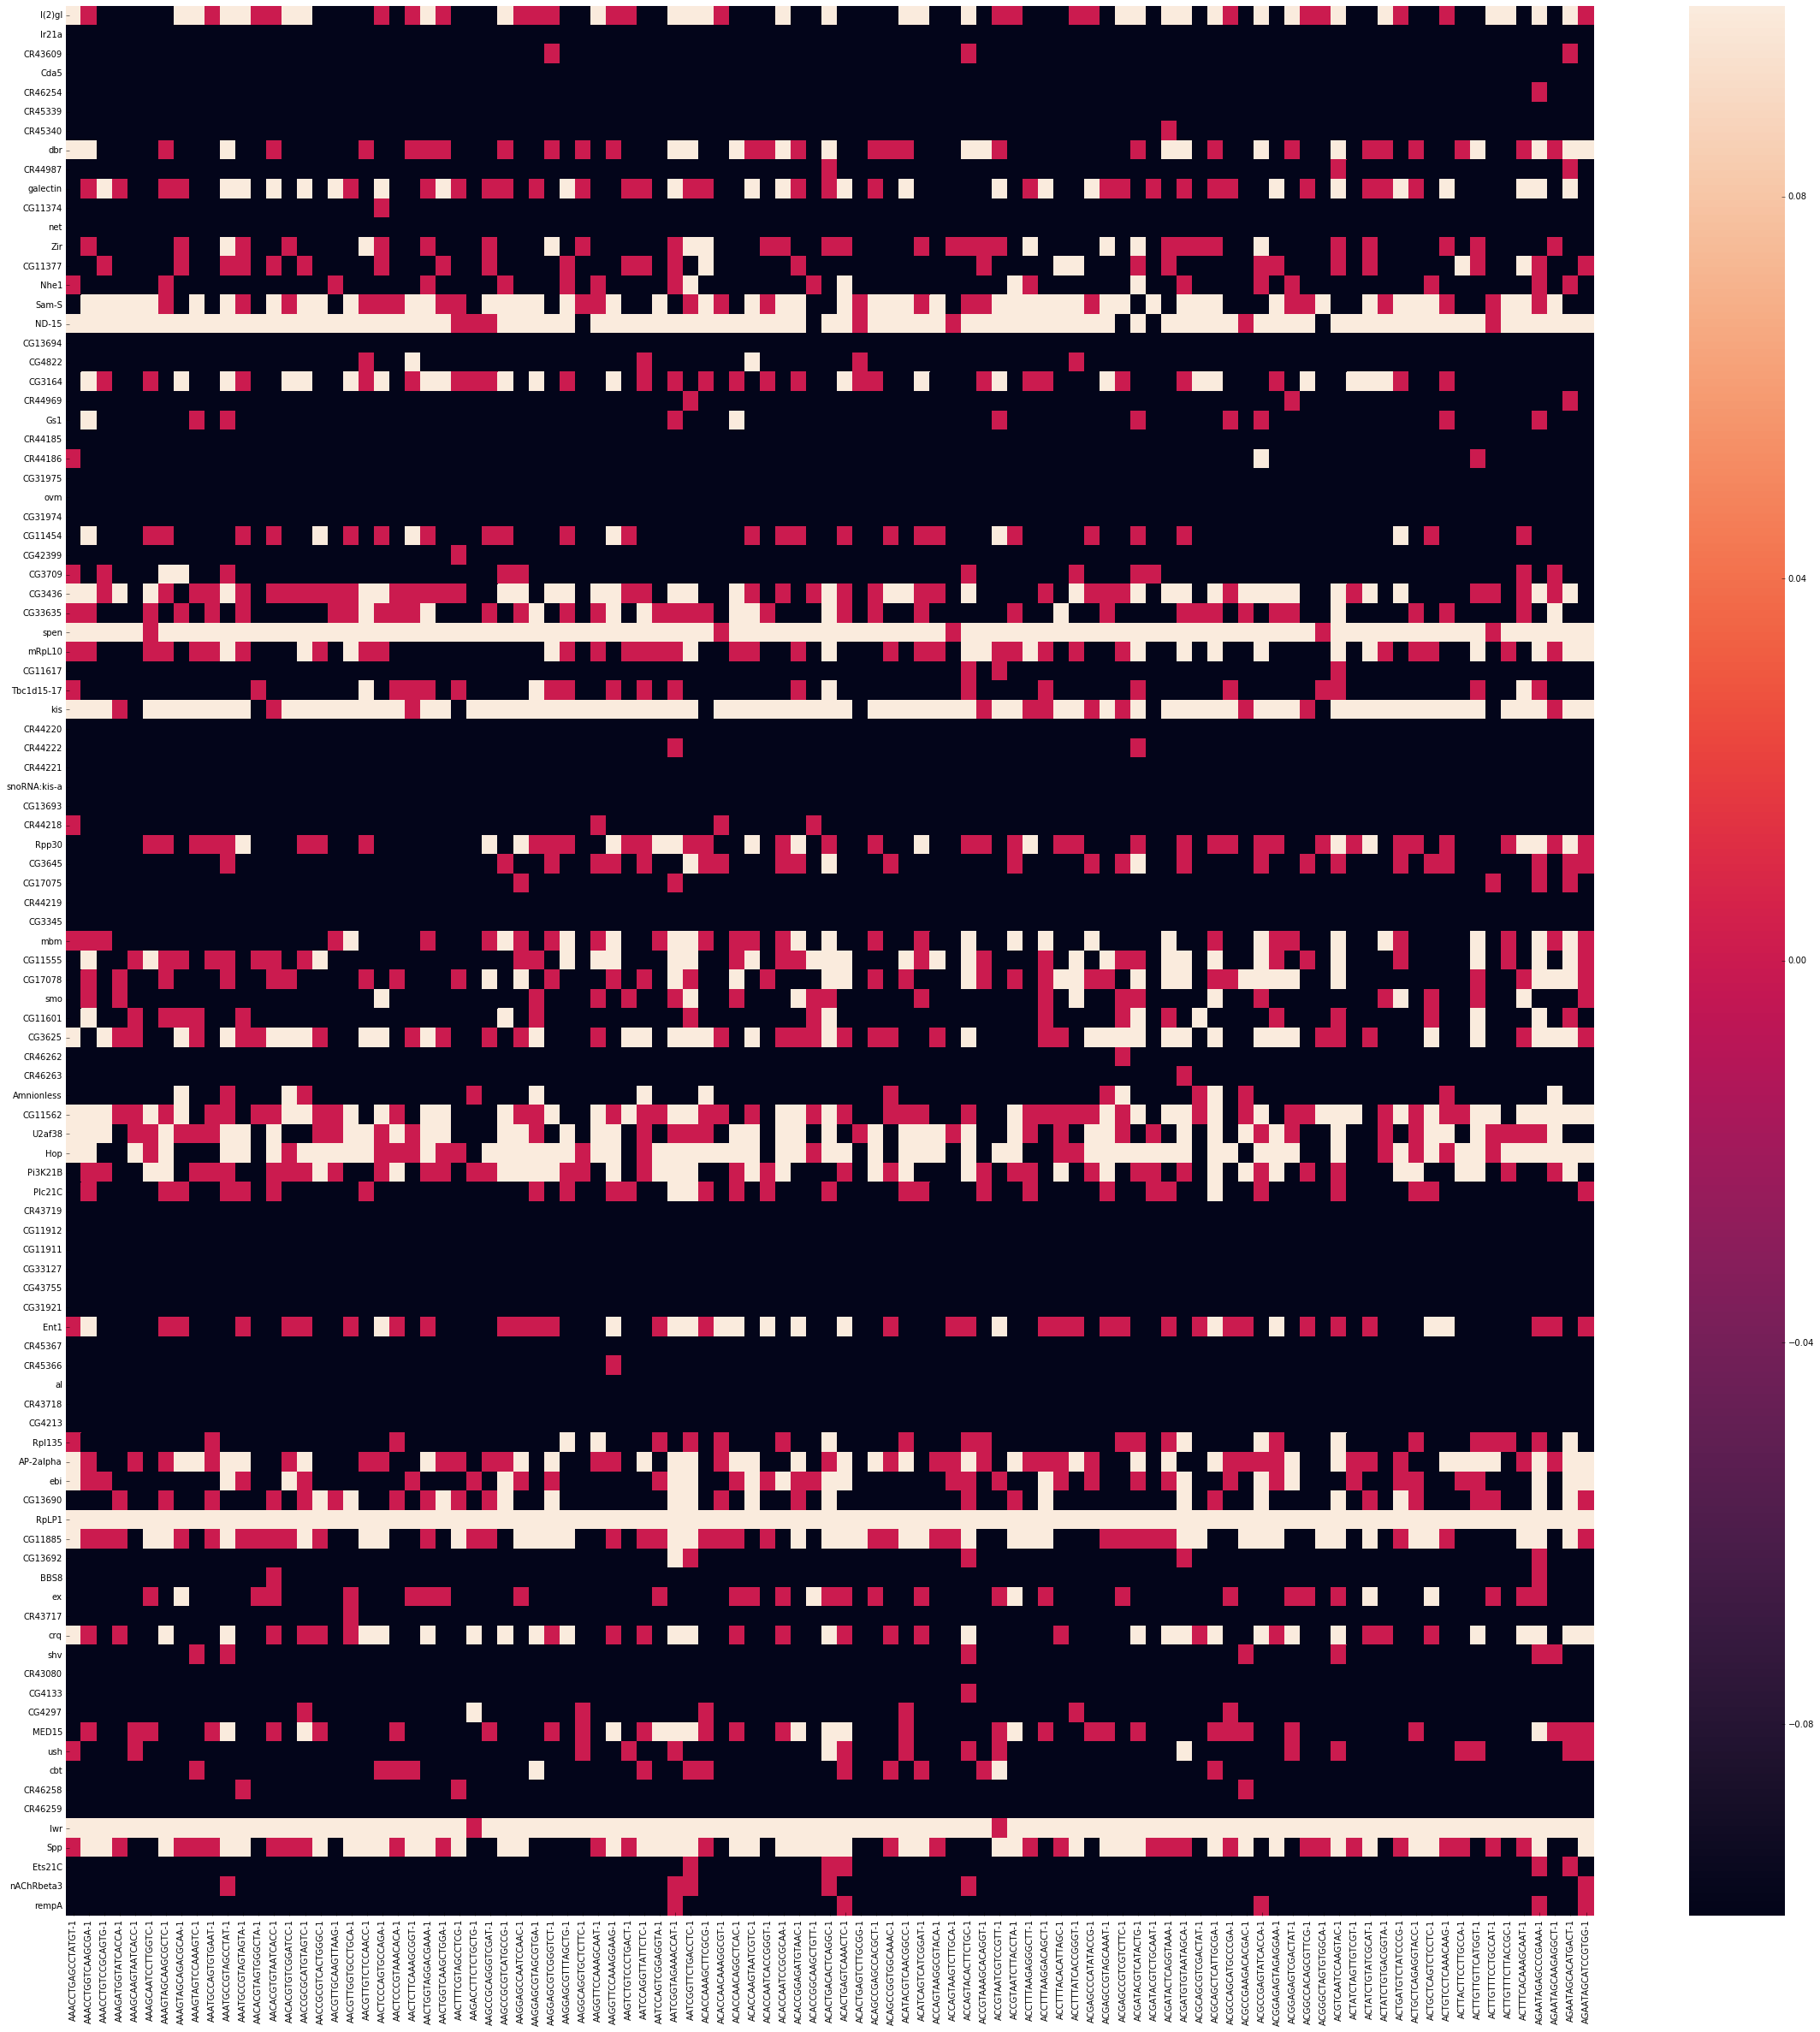

In [5]:
plt.figure(figsize=(40, 40))
sns.heatmap(np.log(data_frames['wtF'].iloc[1:100, 1:100]))

In [23]:
df = data_frames['wtF']
df.shape

(17433, 753)

In [52]:
df = pd.DataFrame(arr)
df.index = gene_names
df.shape

(17433, 1524)

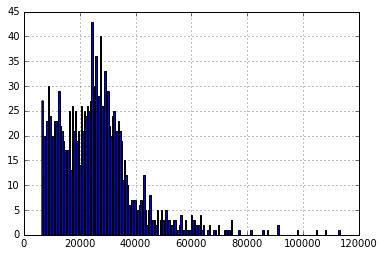

In [10]:
df.sum(axis=0).hist(bins=200)

In [13]:
df.sum(axis=0).min()

6233

## Reproducing tSNE clustering of ~7 cell types

We aim to see if all 7 dataframes can be normalized, filtered and reduced such that their dimensionality reduction clustering recaptures the 7 cell type clusterings. However, it's also possible that the mutant / overexpression data sets have fewer clusters. 

Then, we can take an intermediary data matrix, likely of the variable, normalized genes, and use that as input to the Inferelator

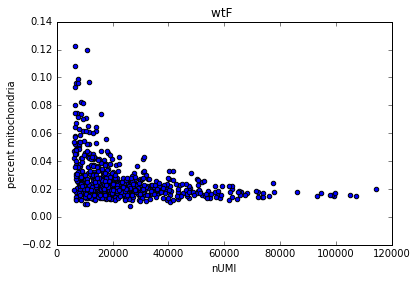

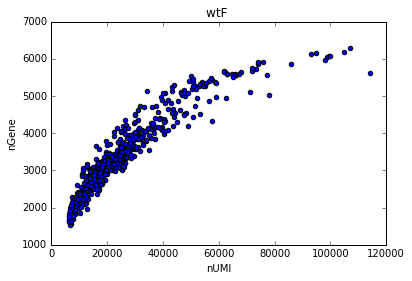

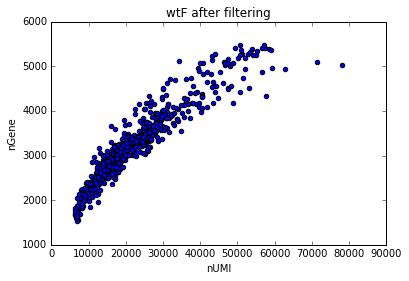

In [123]:
df_key = 'wtF'
original_len = df.shape[1]
mito_df = df[[x.__contains__("mt:") for x in df.index]]
percent_mito = mito_df.sum(axis=0)/df.sum(axis = 0)
nGene = df[df > 0].count(axis = 0)
percent_mito_5percent = percent_mito < 0.05
number_nGene_250 = 250 < nGene 
number_nGene_5000 = nGene < 5500
df_filtered = df.loc[:, percent_mito_5percent & number_nGene_5000 & number_nGene_250]
new_len = df_filtered.shape[1]
nUMI = df.sum(axis = 0)
plt.scatter(nUMI, percent_mito)
plt.xlabel('nUMI')
plt.ylabel('percent mitochondria')
plt.title('{} '.format(df_key))
plt.show()
plt.scatter(nUMI, nGene)
plt.xlabel('nUMI')
plt.ylabel('nGene')
plt.title('{} '.format(df_key))
plt.show()
nGene = df_filtered[df_filtered > 0].count(axis = 0)
nUMI = df_filtered.sum(axis = 0)
plt.scatter(nUMI, nGene)
plt.xlabel('nUMI')
plt.ylabel('nGene')
plt.title('{} after filtering'.format(df_key))
plt.show()


In [161]:
df_nonzero = df_filtered.copy(deep=True)
df_nonzero[df_nonzero > 0] = 1
df_nonzero.shape

(17433, 680)

In [163]:
len(set(df_nonzero.index))

17433

# Convert gene symbols to Gene ids

In [6]:
gtf = pd.read_csv('~/Dev/Drosophila_inferelator/Drosophila_melanogaster.BDGP6.91.genes.gtf', sep='\t', header = None)

In [7]:
gtf.head()

,0,1,2,3,4,5,6,7,8
0,3R,FlyBase,gene,567076,2532932,.,+,.,"gene_id ""FBgn0267431""; gene_name ""Myo81F""; gen..."
1,3R,FlyBase,gene,722370,722621,.,-,.,"gene_id ""FBgn0085804""; gene_name ""CR41571""; ge..."
2,3R,FlyBase,gene,1031171,1031354,.,+,.,"gene_id ""FBgn0039987""; gene_name ""CR12798""; ge..."
3,3R,FlyBase,gene,1366234,1366601,.,-,.,"gene_id ""FBgn0267798""; gene_name ""CR46123""; ge..."
4,3R,FlyBase,gene,1865108,1866008,.,-,.,"gene_id ""FBgn0267797""; gene_name ""CR46122""; ge..."


In [8]:
gene_sym_to_id = {}

In [9]:
for (idx, row) in gtf.iterrows():
    st = row[8]
    splits = st.split(';')
    i = splits[0].split(" ")[1].strip('"')
    sym = splits[1].split(" ")[2].strip('"').rstrip(';').rstrip('"').replace(';', '')
    gene_sym_to_id[sym] = i
    # UpperCase first letter
    # gene_sym_to_id[sym.title()] = i
    

In [10]:
len(gene_sym_to_id)

17737

In [57]:
gene_sym_to_id['Rab21']

'FBgn0039966'

In [41]:
'Ime4'.lower()

'ime4'

In [214]:
fraction_nonzero = 0.05
idx = df_nonzero.index[df_nonzero.sum(axis=1) > float(df_nonzero.shape[1]) * fraction_nonzero]
exp = df_filtered.loc[idx, :]
exp.shape

(6975, 680)

In [215]:
exp = exp.loc[set(gene_sym_to_id.keys()).intersection(exp.index), :]
new_index = [gene_sym_to_id[sym] for sym in exp.index]
new_index[0:10]

['FBgn0039266',
 'FBgn0039265',
 'FBgn0031006',
 'FBgn0025558',
 'FBgn0016978',
 'FBgn0033155',
 'FBgn0283500',
 'FBgn0015714',
 'FBgn0037719',
 'FBgn0051710']

In [193]:
import collections
dupes = [item for item, count in collections.Counter(new_index).items() if count > 1]
dupes

['FBgn0004864', 'FBgn0010452', 'FBgn0260632', 'FBgn0001168']

In [198]:
for k in set(gene_sym_to_id.keys()).intersection(exp.index):
    if gene_sym_to_id[k] in dupes:
        print k

hop
Hop
trn
h
dl
Trn
Dl
H


In [209]:
df.loc['Trn']

AAACCTGAGAGGACGG-1    1
AAACCTGAGCCTATGT-1    7
AAACCTGGTCAAGCGA-1    7
AAACCTGTCCGCAGTG-1    2
AAAGATGGTATCACCA-1    2
AAAGCAAGTAATCACC-1    1
AAAGCAATCCTTGGTC-1    3
AAAGTAGCAAGCGCTC-1    7
AAAGTAGCAGACGCAA-1    0
AAAGTAGTCCAAAGTC-1    0
AAATGCCAGTGTGAAT-1    2
AAATGCCGTAGCCTAT-1    9
AAATGCCGTAGTAGTA-1    2
AACACGTAGTGGGCTA-1    0
AACACGTGTAATCACC-1    5
AACACGTGTCGGATCC-1    1
AACCGCGCATGTAGTC-1    4
AACCGCGTCACTGGGC-1    1
AACGTTGCAAGTTAAG-1    1
AACGTTGGTGCCTGCA-1    2
AACGTTGTCTCCAACC-1    0
AACTCCCAGTGCCAGA-1    1
AACTCCCGTAAACACA-1    0
AACTCTTCAAAGCGGT-1    1
AACTGGTAGGACGAAA-1    1
AACTGGTCAAGCTGGA-1    1
AACTTTCGTAGCCTCG-1    1
AAGACCTTCTCTGCTG-1    1
AAGCCGCAGGGTCGAT-1    2
AAGCCGCGTCATGCCG-1    1
                     ..
TTAGGACGTATTCTCT-1    0
TTAGGCAGTCTGGTCG-1    1
TTATGCTCAACCGCCA-1    0
TTATGCTCACCAACCG-1    2
TTCCCAGAGGACTGGT-1    0
TTCCCAGGTCGCTTTC-1    3
TTCCCAGTCCCAAGAT-1    2
TTCGAAGTCCTTTCTC-1    0
TTCGGTCAGTCATCCA-1    4
TTCGGTCGTTCATGGT-1    1
TTCTACACAAAGTGCG

In [217]:
len(set(new_index))

6915

In [218]:
exp.index = new_index
len(new_index)

6915

In [219]:
exp.to_csv('expression.tsv', sep='\t')

In [150]:
fraction_nonzero = 0.01
idx = df_nonzero.index[df_nonzero.sum(axis=1) > float(df.shape[1]) * fraction_nonzero]
with_expression_ids = [gene_sym_to_id[sym] for sym in idx if sym in gene_sym_to_id.keys()]
with_expression_tfs = list(set(with_expression_ids).intersection(set(prior.columns)))
prior = pd.read_csv('~/Dev/inferelator_ng/data/dmel/gold_standard.tsv', sep='\t', index_col = 0)
prior_with_expression = prior[with_expression_tfs]


In [151]:
with_expression_tfs = list(set(with_expression_ids).intersection(set(prior.columns)))

prior_with_expression.to_csv('~/Dev/inferelator_ng/data/dmel/prior_with_tfs_filtered_by_one_percent_expression.tsv', sep='\t', index_col = 0)

In [152]:
prior_with_expression.head()

,FBgn0004396,FBgn0004652,FBgn0004837,FBgn0005660,FBgn0032130,FBgn0001269,FBgn0036126,FBgn0014018,FBgn0011648,FBgn0003567,...,FBgn0000560,FBgn0011655,FBgn0000568,FBgn0000166,FBgn0001994,FBgn0038418,FBgn0054031,FBgn0019650,FBgn0022935,FBgn0000546
FBgn0000003,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
FBgn0000008,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
FBgn0000015,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
FBgn0000017,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
FBgn0000018,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0


In [158]:
len(prior_with_expression.index)

5936

In [159]:
len(set(prior_with_expression.index))

5936

In [160]:
len(set(prior_with_expression.columns))

166

In [196]:
len(set(exp.index))

6917

In [197]:
len(exp.index)

6917

In [131]:
prior.head()

,FBgn0015239,FBgn0086680,FBgn0004396,FBgn0004652,FBgn0004394,FBgn0001147,FBgn0004837,FBgn0011723,FBgn0000576,FBgn0010433,...,FBgn0000462,FBgn0000459,FBgn0001983,FBgn0054031,FBgn0031573,FBgn0003145,FBgn0000014,FBgn0000659,FBgn0015561,FBgn0000546
FBgn0000003,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
FBgn0000008,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
FBgn0000015,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
FBgn0000017,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
FBgn0000018,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


RuntimeError: maximum recursion depth exceeded while calling a Python object

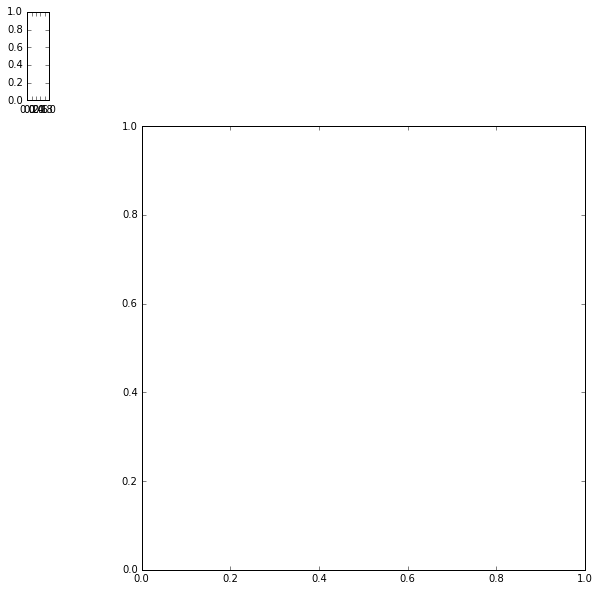

In [181]:
plt.figure(figsize=(100,100))
sns.clustermap(exp)

In [ ]:
import collections
dupes = [item for item, count in collections.Counter(new_index).items() if count > 1]

In [54]:
len(set(df.index))

17433

In [46]:
len(new_index)

5338

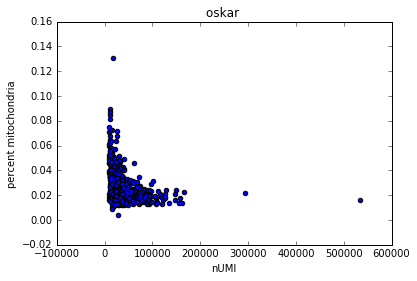

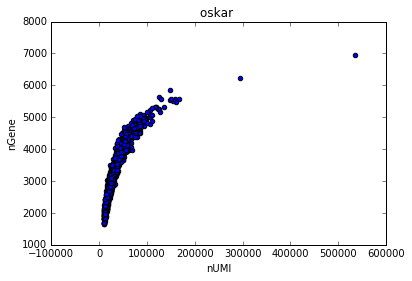

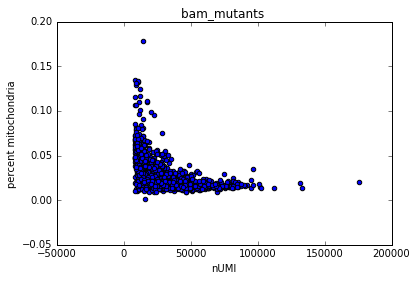

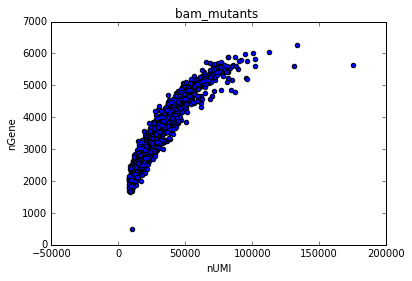

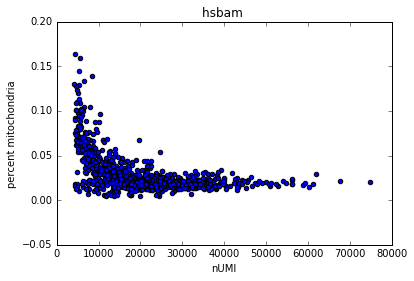

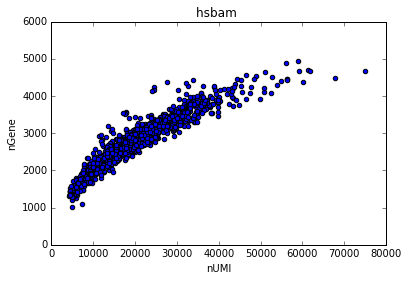

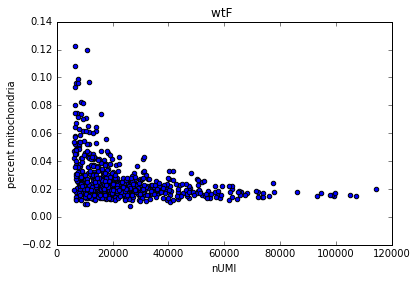

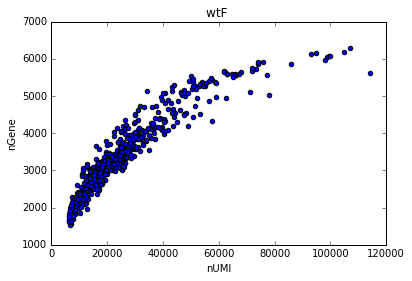

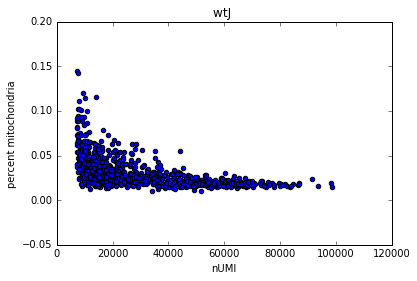

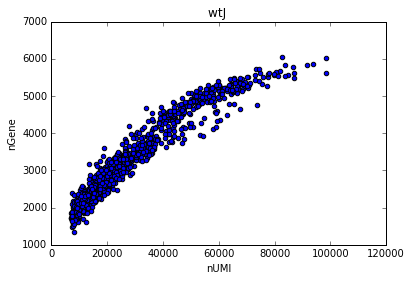

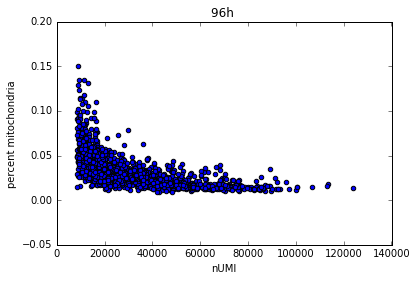

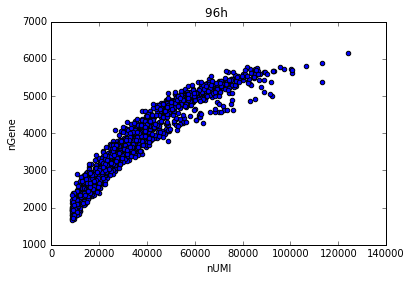

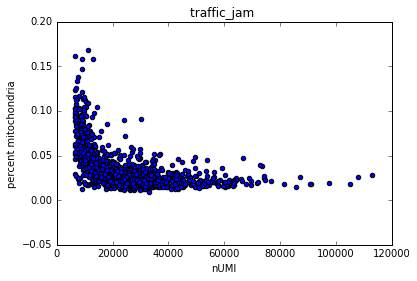

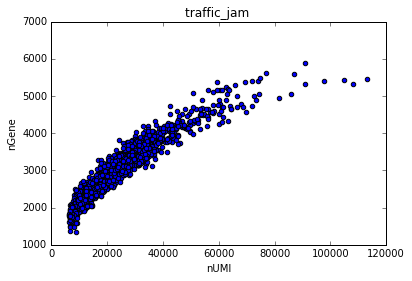

In [19]:
filtered_data_frames = {}
filtered_lengths = {}
for df_key in data_frames:
    df = data_frames[df_key]
    original_len = df.shape[1]
    mito_df = df[[x.__contains__("mt:") for x in df.index]]
    percent_mito = mito_df.sum(axis=0)/df.sum(axis = 0)
    nGene = df[df > 0].count(axis = 0)
    percent_mito_5percent = percent_mito < 0.05
    number_nGene_250 = 250 < nGene 
    number_nGene_5000 = nGene < 6000
    df_filtered = df.loc[:, percent_mito_5percent & number_nGene_5000 & number_nGene_250]
    new_len = df_filtered.shape[1]
    nUMI = df.sum(axis = 0)
    plt.scatter(nUMI, percent_mito)
    plt.xlabel('nUMI')
    plt.ylabel('percent mitochondria')
    plt.title('{} '.format(df_key))
    plt.show()
    plt.scatter(nUMI, nGene)
    plt.xlabel('nUMI')
    plt.ylabel('nGene')
    plt.title('{} '.format(df_key))
    plt.show()
    filtered_lengths[df_key] = (original_len, new_len)
    filtered_data_frames[df_key] = df_filtered

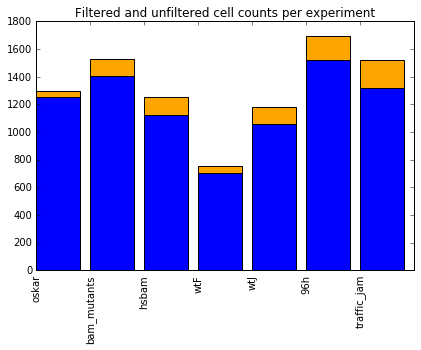

In [20]:
idx = np.arange(len(filtered_lengths))
plt.bar(idx, [x[0] for x in filtered_lengths.values()], color='orange')
plt.bar(idx, [x[1] for x in filtered_lengths.values()])
plt.tight_layout()
plt.xticks(idx, filtered_lengths.keys(),  rotation='vertical')
plt.title('Filtered and unfiltered cell counts per experiment')
plt.show()


In [15]:
germ_cell_metagene = ['bru1',
'Pdcd4',
'RpS5b',
'AGO3',
'vas',
'ovo',
'TfIIA-S',
'CG9926']

In [16]:
len(germ_cell_metagene)

8

In [25]:
non_zero_genes = df[df.sum(axis =1) > 100].index

In [26]:
len(non_zero_genes)

6563

In [27]:
# Prove that the germ cell metagenes are enriched in the >5000 nGene set. 

In [28]:
nGene = df[df > 0].count(axis = 0)

In [29]:
high_count_samples = df.columns[nGene > 5000]

In [30]:
dset = 'wtF'
all_present_samples = df.columns[(df.loc[germ_cell_metagene, :] > 0).sum(axis=0) == 8]
germline_ratio = len(set(high_count_samples).intersection(all_present_samples)) / float(len(all_present_samples))
germline_ratio

0.6039603960396039

In [33]:
len(all_present_samples)

101

In [31]:
meta_index = np.random.choice(len(non_zero_genes), 8, replace=False)

In [32]:
non_zero_genes[meta_index]

Index([u'CG6567', u'Marf', u'lva', u'pbl', u'yrt', u'CG11593', u'fs(1)Yb',
       u'Usp20-33'],
      dtype='object')

In [37]:
ratios = []
# sample 1000 combos of 8 genes from the genes expressed list, see if their enrichment is higher in the germ cell metagene
for i in range(100000):
    random_metagene_index = np.random.choice(len(non_zero_genes), 8, replace=False)
    metagene = non_zero_genes[random_metagene_index]
    all_present_samples = df.columns[(df.loc[metagene, :] > 0).sum(axis=0) == 8]
    # Only count similarly sized samples, +/- 21
    if len(all_present_samples) > 80 and len(all_present_samples) < 122: 
        r = len(set(high_count_samples).intersection(all_present_samples)) / float(len(all_present_samples) + 1)
        ratios.append(r)

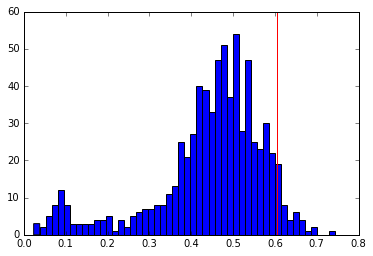

In [44]:
plt.hist(ratios, bins = 50)
plt.axvline(x=germline_ratio, color='red')


[]

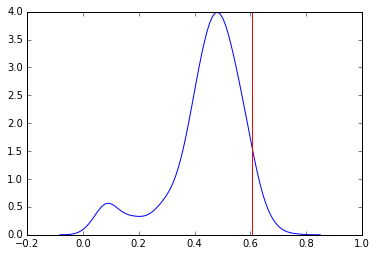

In [43]:
ax = sns.kdeplot(ratios)
plt.axvline(x=germline_ratio, color='red')
plt.plot()

In [52]:
## what top percent is the germline ratio in compared to length-8 metagenes with similar number of samples?
sum([ratio > germline_ratio for ratio in ratios]) / float(len(ratios))

0.05075445816186557

The first run suggested to me that there is nothing very special about the germcell metagene for predicting high nGene, but once we controlled for very small and very large sets, it seems to at least be

In [54]:
### Average NGene number per metagene

In [74]:
all_present_samples = df.columns[(df.loc[germ_cell_metagene, :] > 0).sum(axis=0) == 8]
germline_ratio = len(set(high_count_samples).intersection(all_present_samples)) / float(len(all_present_samples))
germline_ratio

0.6039603960396039

In [75]:
np.mean(nGene[all_present_samples])

4914.5247524752476

In [76]:
germline_median = np.median(nGene[all_present_samples])

In [77]:
medians = []
# sample 1000 combos of 8 genes from the genes expressed list, see if their enrichment is higher in the germ cell metagene
for i in range(100000):
    random_metagene_index = np.random.choice(len(non_zero_genes), 8, replace=False)
    metagene = non_zero_genes[random_metagene_index]
    all_present_samples = df.columns[(df.loc[metagene, :] > 0).sum(axis=0) == 8]
    # Only count similarly sized samples, +/- 21
    if len(all_present_samples) > 80 and len(all_present_samples) < 122: 
        medians.append(np.median(nGene[all_present_samples]))

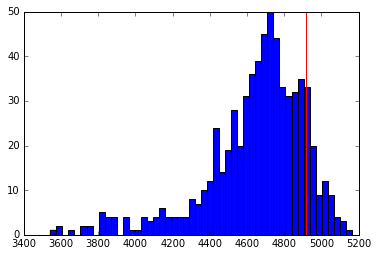

In [73]:
plt.hist(means, bins = 50)
plt.axvline(x=germline_mean, color='red')


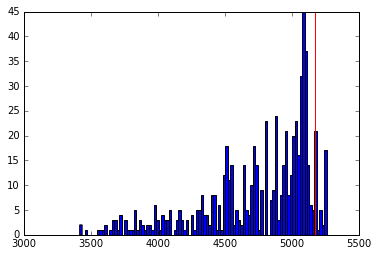

In [80]:
plt.hist(medians, bins = 100)
plt.axvline(x=germline_median, color='red')

[]

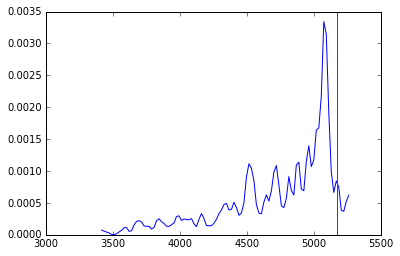

In [85]:
ax = sns.kdeplot(medians, bw=0.04)
plt.axvline(x=germline_median, color='red')
plt.plot()

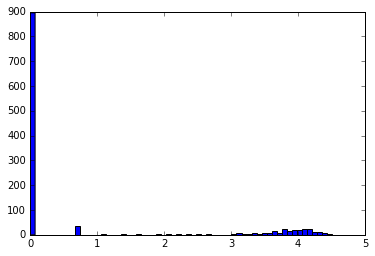

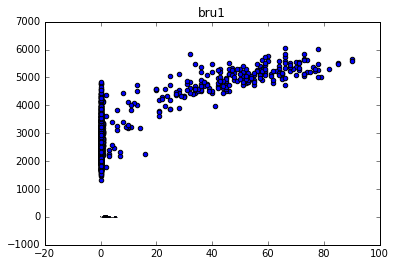

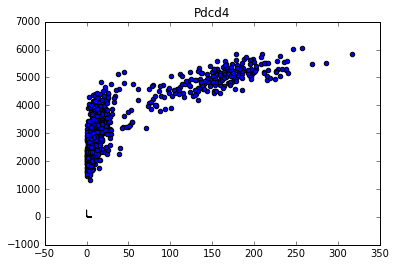

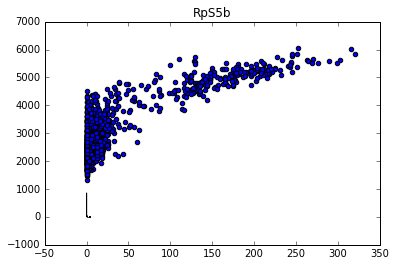

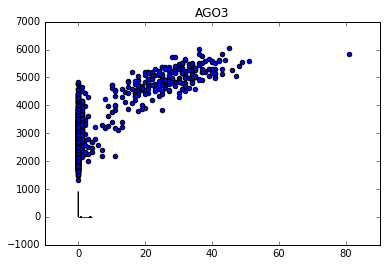

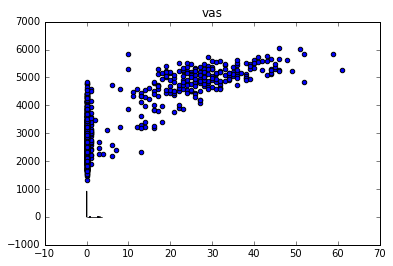

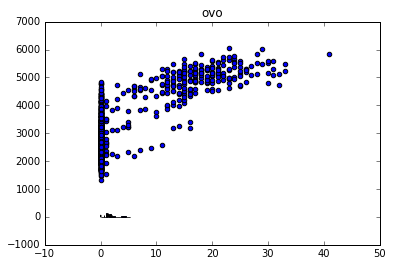

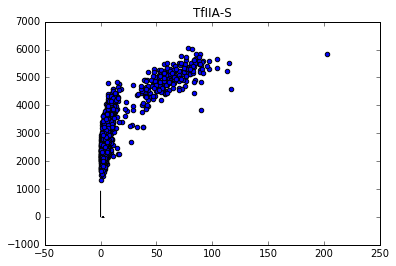

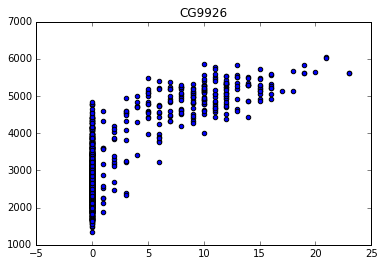

In [69]:
for gene in germ_cell_metagene:
    df = data_frames[dset]
    plt.hist(np.log(df.loc[gene, :] + 1), bins=60)
    plt.show()
    nGene = df[df > 0].count(axis = 0)
    plt.scatter(df.loc[gene, :], nGene)
    plt.title(gene)

In [288]:
combined = pd.concat(filtered_data_frames.values(), join='outer', axis  =1 )


In [289]:
combined.shape

(17433, 7807)

In [296]:
scale_factor = 10000
# pseudocount added so that log isn't taken of 0
combined_transformed = np.log((combined / combined.sum() *  scale_factor) + 1)

In [302]:
combined_transformed.to_csv(os.path.join(matrices_dir, "filtered_log_transformed_merged_reads.tsv"), sep='\t')

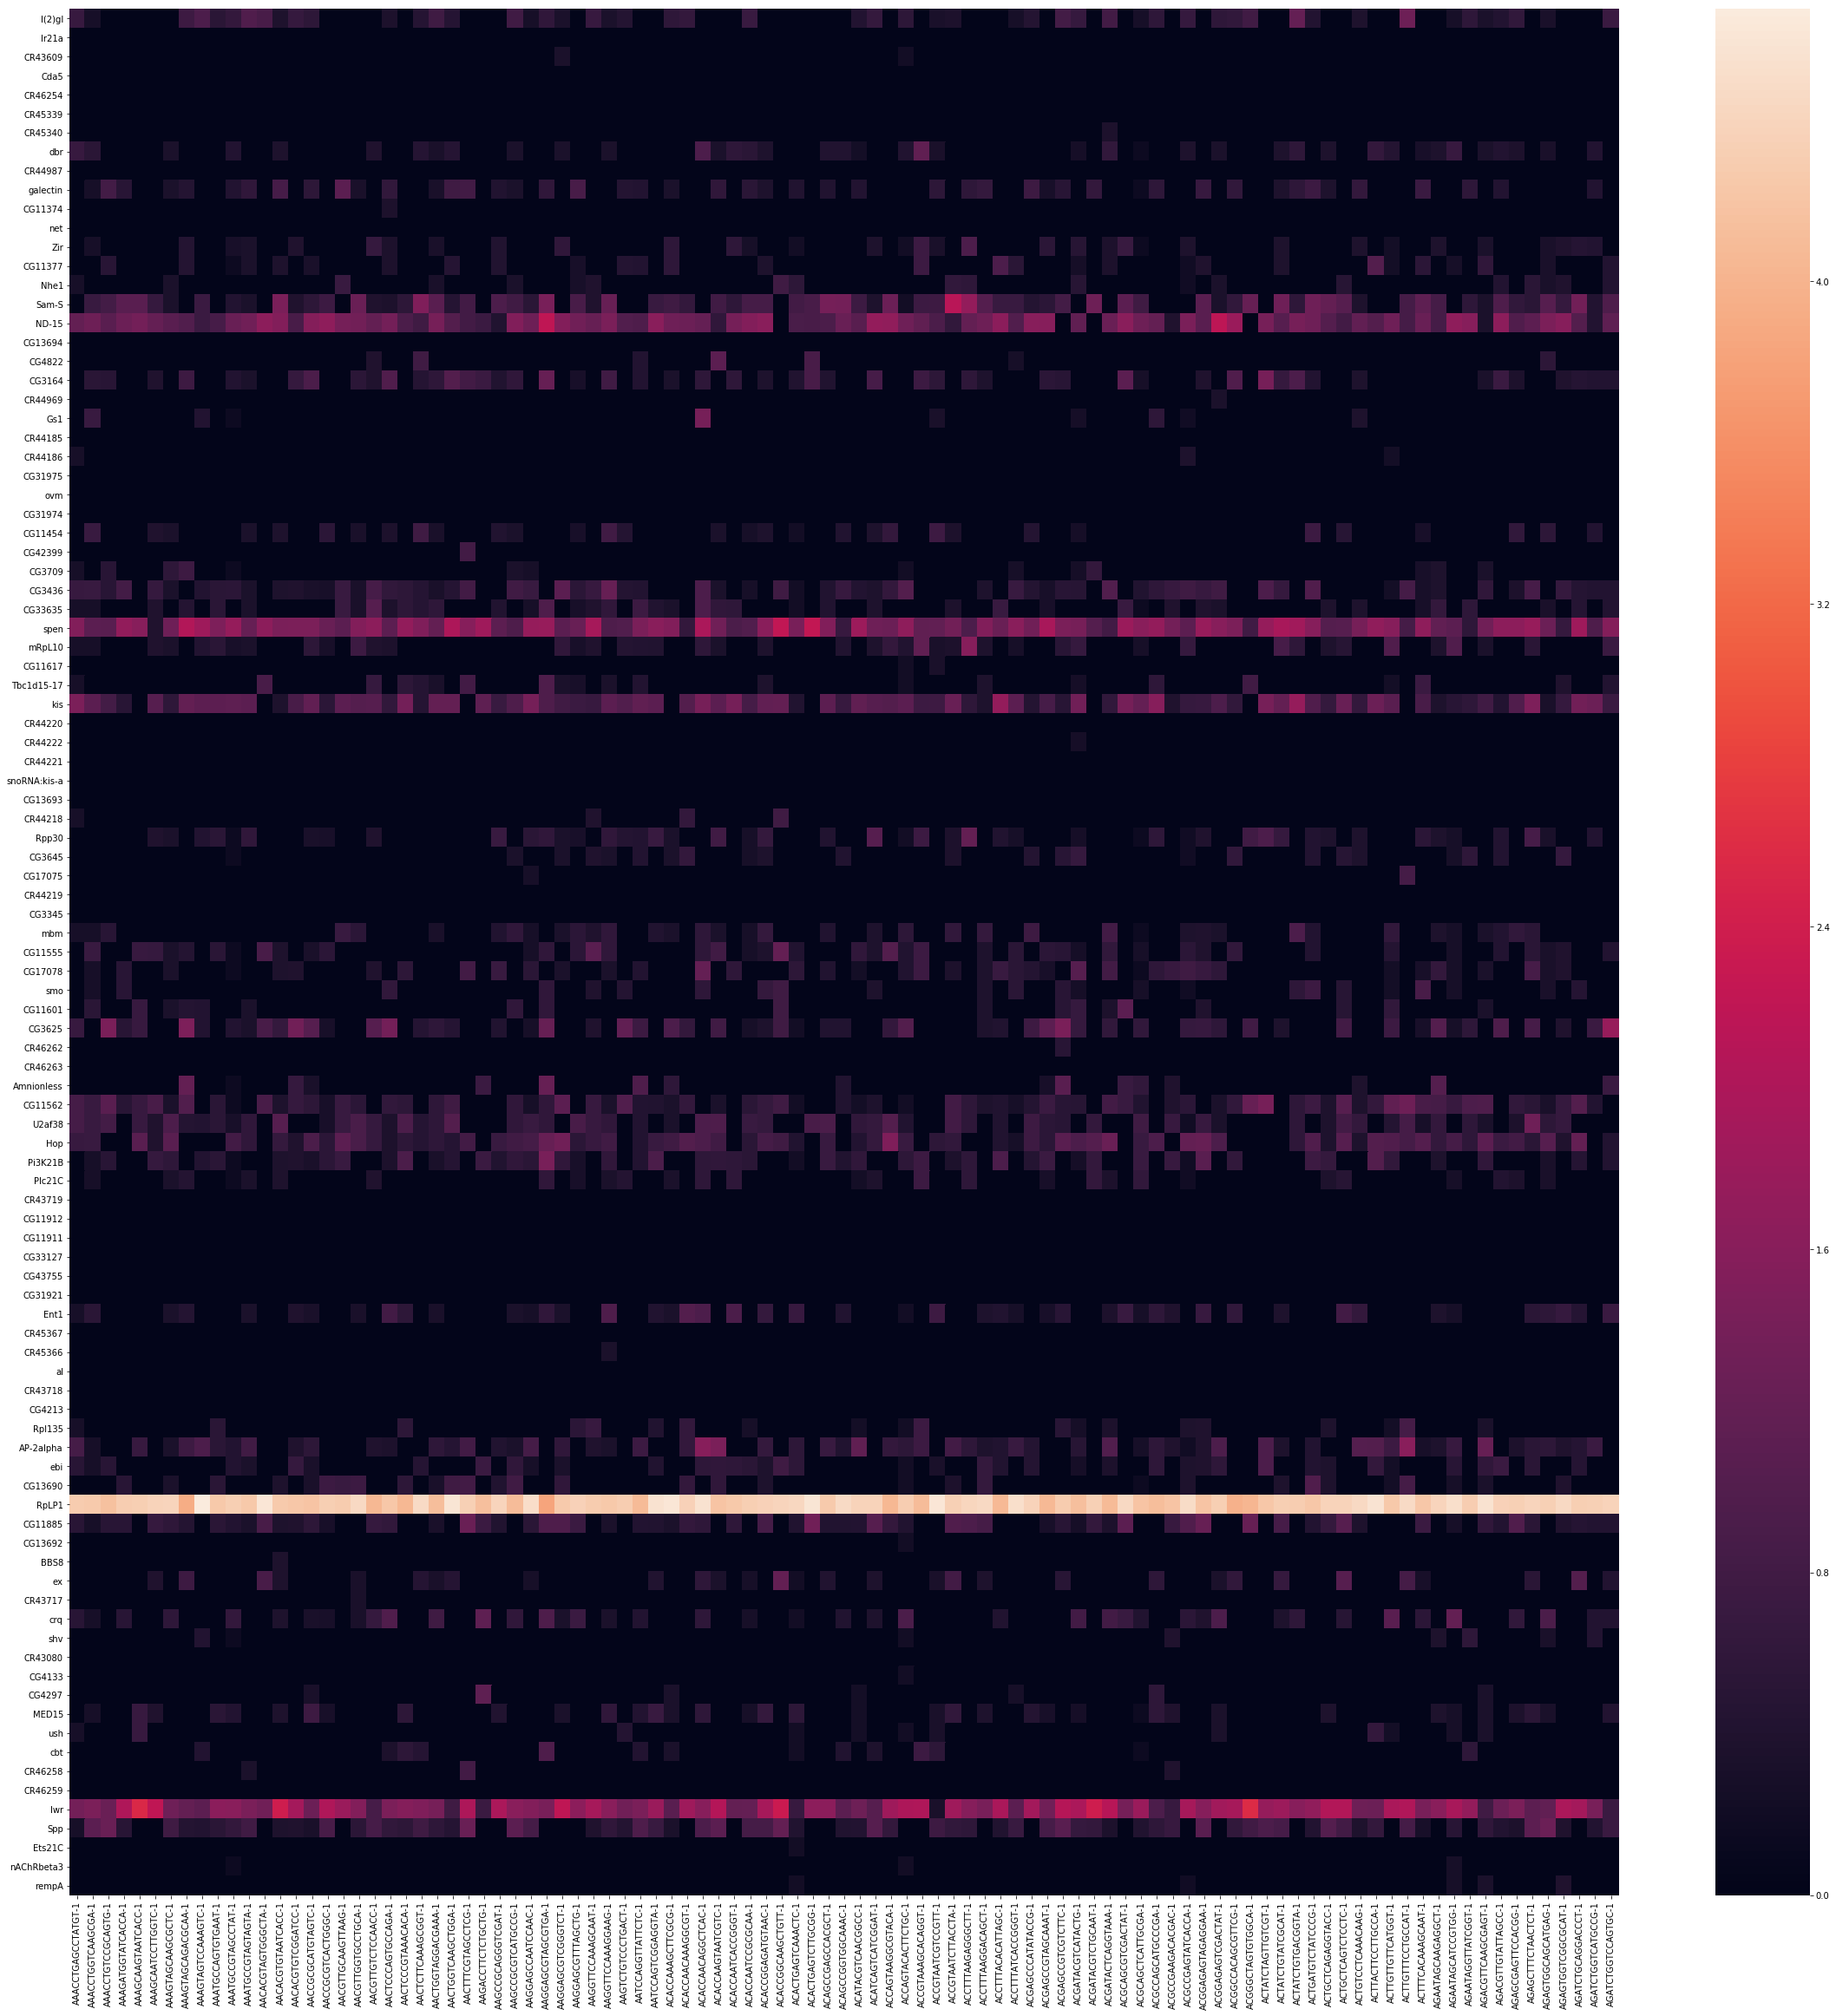

In [300]:
plt.figure(figsize=(40, 40))
sns.heatmap(combined_transformed.iloc[1:100, 1:100])

In [301]:
combined_transformed.shape

(17433, 7807)

In [303]:
combined_transformed.iloc[:, 1:100].to_csv(os.path.join(matrices_dir, "expression.tsv"), sep='\t')

In [ ]:
plt.bar(np.arange(len(filtered_lengths)), [x[0] for x in filtered_lengths.values()])

In [266]:
[x[0] for x in filtered_lengths.values()]

[753, 1178, 1526, 1294, 1524, 1252, 1697]

In [250]:
nGene_wt1 = df_wt1[df_wt1 > 0].count(axis = 0)

In [251]:
percent_mito_5percent_wt1 = percent_mito_wt1<0.05

In [252]:
percent_nGene_5000_wt1 = nGene_wt1<5000

In [253]:
df_filtered_wt1 = df_wt1.loc[:, percent_mito_5percent_wt1 & percent_nGene_5000_wt1]

In [254]:
filtered_data_frames['wt1'] = df_filtered

In [255]:
df_filtered_wt1.head()

,AAACCTGAGAGGACGG-1,AAACCTGAGCCTATGT-1,AAACCTGGTCAAGCGA-1,AAACCTGTCCGCAGTG-1,AAAGATGGTATCACCA-1,AAAGCAAGTAATCACC-1,AAAGCAATCCTTGGTC-1,AAAGTAGCAAGCGCTC-1,AAAGTAGCAGACGCAA-1,AAAGTAGTCCAAAGTC-1,...,TTGCGTCCAGCCACCA-1,TTGGAACAGTGTTAGA-1,TTGGAACGTGGTCTCG-1,TTGGAACTCCTTCAAT-1,TTGGAACTCTGCGACG-1,TTGTAGGCAGACACTT-1,TTTACTGAGAAGAAGC-1,TTTATGCGTAGAAGGA-1,TTTGCGCAGTACGCGA-1,TTTGGTTGTCCCTACT-1
CG11023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
l(2)gl,1,3,1,0,0,0,0,0,2,3,...,3,0,4,0,0,2,2,7,2,1
Ir21a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CR43609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Cda5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Text(0.5,0.98,u'wt2 filtered')

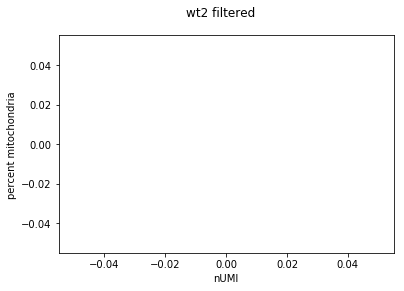

In [166]:
plt.scatter(nUMI, percent_mito)
plt.xlabel('nUMI')
plt.ylabel('percent mitochondria')
plt.suptitle('wt2 filtered')

Text(0.5,0.98,u'wt1')

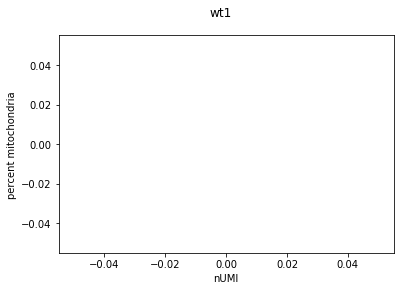

In [155]:
plt.scatter(nUMI, percent_mito)
plt.xlabel('nUMI')
plt.ylabel('percent mitochondria')

Text(0,0.5,u'nGene')

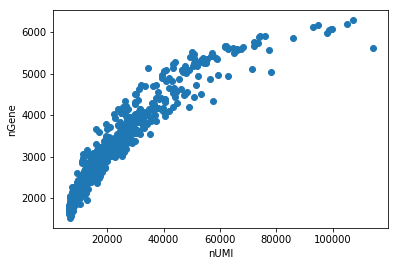

In [99]:
plt.scatter(nUMI, nGene)
plt.xlabel('nUMI')
plt.ylabel('nGene')

In [ ]:
df_filtered = df.loc[:, percent_mito_5percent & percent_nGene_5000]

In [79]:
mito_df = df[[x.__contains__("mt:") for x in df.index]]

mito_df.sum(axis=0)

AAACCTGAGAGGACGG-1     347
AAACCTGAGCCTATGT-1     818
AAACCTGGTCAAGCGA-1     629
AAACCTGTCCGCAGTG-1     261
AAAGATGGTATCACCA-1     332
AAAGCAAGTAATCACC-1     154
AAAGCAATCCTTGGTC-1     553
AAAGTAGCAAGCGCTC-1     459
AAAGTAGCAGACGCAA-1     306
AAAGTAGTCCAAAGTC-1     280
AAATGCCAGTGTGAAT-1     356
AAATGCCGTAGCCTAT-1    1249
AAATGCCGTAGTAGTA-1     560
AACACGTAGTGGGCTA-1     262
AACACGTGTAATCACC-1     426
AACACGTGTCGGATCC-1     435
AACCGCGCATGTAGTC-1     672
AACCGCGTCACTGGGC-1     877
AACGTTGCAAGTTAAG-1     164
AACGTTGGTGCCTGCA-1     615
AACGTTGTCTCCAACC-1     410
AACTCCCAGTGCCAGA-1     503
AACTCCCGTAAACACA-1     251
AACTCTTCAAAGCGGT-1     412
AACTGGTAGGACGAAA-1     467
AACTGGTCAAGCTGGA-1     342
AACTTTCGTAGCCTCG-1     157
AAGACCTTCTCTGCTG-1     194
AAGCCGCAGGGTCGAT-1     447
AAGCCGCGTCATGCCG-1     631
                      ... 
TTAGGACGTATTCTCT-1     302
TTAGGCAGTCTGGTCG-1     416
TTATGCTCAACCGCCA-1     292
TTATGCTCACCAACCG-1     485
TTCCCAGAGGACTGGT-1     445
TTCCCAGGTCGCTTTC-1     647
T

In [220]:
exp.shape

(6915, 680)

In [221]:
prior.shape

(5936, 328)

In [230]:
exp.shape[0] / float(len(df.index))

0.39666150404405437

In [239]:
float(len(df.index))

17433.0

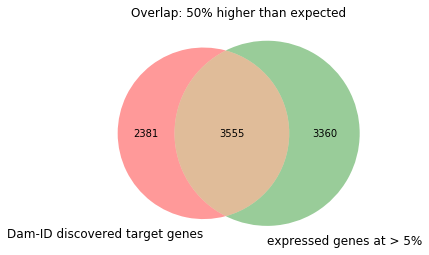

In [238]:
from matplotlib_venn import venn2
venn2([prior.index, exp.index], set_labels = ('Dam-ID discovered target genes', 'expressed genes at > 5%'))
plt.title('Overlap: 50% higher than expected')

In [227]:
len(set(prior.index).intersection(exp.index)) / float(prior.shape[0])

0.5988881401617251

In [75]:
mitogenes = df[[x.__contains__("mt:") for x in df.index]].index

Index([u'mt:tRNA:Ile-GAT', u'mt:tRNA:Gln-TTG', u'mt:tRNA:Met-CAT', u'mt:ND2',
       u'mt:tRNA:Trp-TCA', u'mt:tRNA:Cys-GCA', u'mt:tRNA:Tyr-GTA', u'mt:CoI',
       u'mt:tRNA:Leu-TAA', u'mt:CoII', u'mt:tRNA:Lys-CTT', u'mt:tRNA:Asp-GTC',
       u'mt:ATPase8', u'mt:ATPase6', u'mt:CoIII', u'mt:tRNA:Gly-TCC',
       u'mt:ND3', u'mt:tRNA:Ala-TGC', u'mt:tRNA:Arg-TCG', u'mt:tRNA:Asn-GTT',
       u'mt:tRNA:Ser-GCT', u'mt:tRNA:Glu-TTC', u'mt:tRNA:Phe-GAA', u'mt:ND5',
       u'mt:tRNA:His-GTG', u'mt:ND4', u'mt:ND4L', u'mt:tRNA:Thr-TGT',
       u'mt:tRNA:Pro-TGG', u'mt:ND6', u'mt:Cyt-b', u'mt:tRNA:Ser-TGA',
       u'mt:ND1', u'mt:tRNA:Leu-TAG', u'mt:lrRNA', u'mt:tRNA:Val-TAC',
       u'mt:srRNA'],
      dtype='object')

In [58]:
'4mt:6'.__contains__("mt:")

True